In [1]:
import pandas as pd

In [213]:
import importlib

import src.ingest_clean 
importlib.reload(src.ingest_clean)
from src.ingest_clean import *

import src.feature_engineering 
importlib.reload(src.feature_engineering)
from src.feature_engineering import *

import src.utils 
importlib.reload(src.utils)
from src.utils import *

## Introduction

In [ ]:
cnpv_fetch_per_hog_top5() # fetch the data from DANE webpage for the top 5 departaments with historical malaria issues
combine_cnpv_per_hog() # Combine the datasets fetched in the first step 

[*] Downloading GeoJSON from OpenDataSoft…
[*] Valid 5-digit mpio_code ratio: 100.0%
[✓] Saved: data_raw/colombia_mpios\colombia_mpios_opendatasoft.gpkg | data_raw/colombia_mpios\colombia_mpios_opendatasoft.shp


c:\Users\alina\Documents\IDB Assesment\policy-analytics-assessment\src\utils.py:45: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  return gdf
c:\Users\alina\anaconda3\envs\policy-analytics\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'geo_point_2d' to 'geo_point_'
  ogr_write(
c:\Users\alina\anaconda3\envs\policy-analytics\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 487395849.13099998 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
c:\Users\alina\anaconda3\envs\policy-analytics\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 533112000.43400002 of field area of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
c:\Users\alina\anaconda3\envs\policy-analytics\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 170026873.

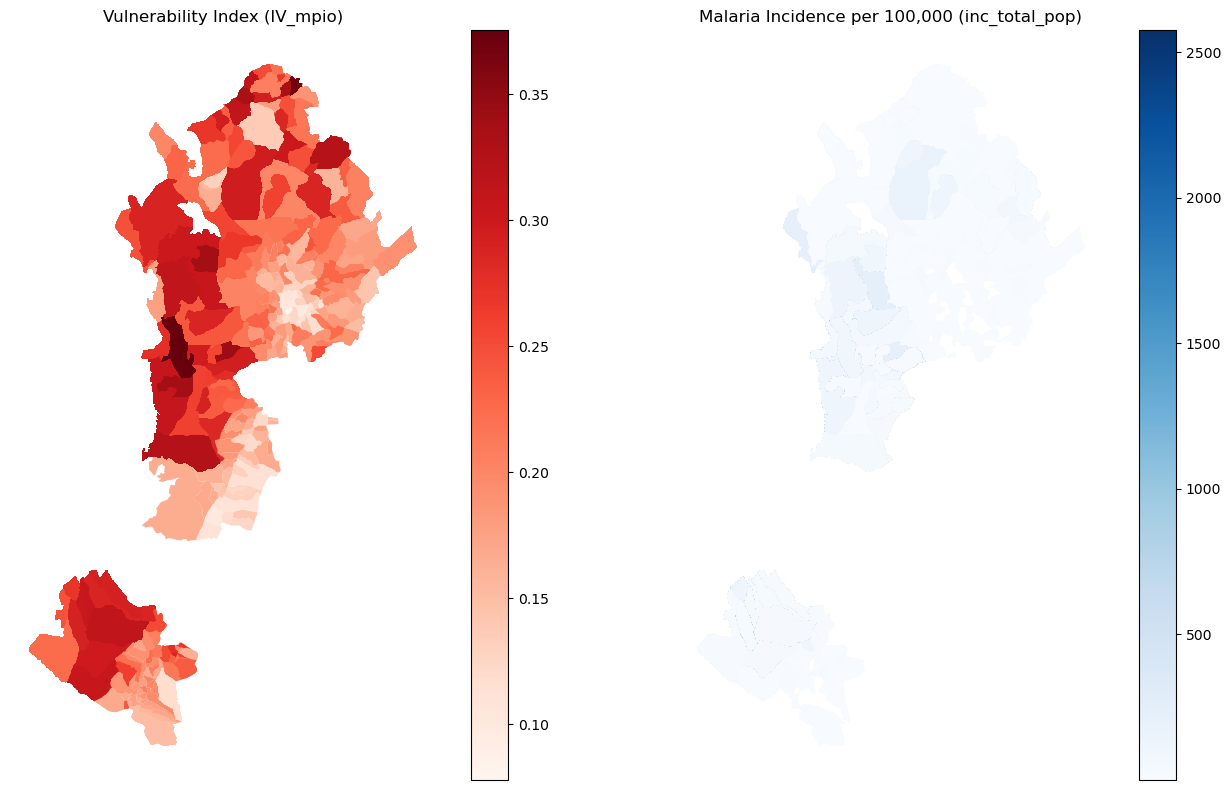

In [ ]:
gdf_mpios = download_mpios_gdf()  # o deja que make_maps lo llame


Top 5 departments by cases:
department  cases
     CHOCO 297749
 ANTIOQUIA 236677
   NARIÃO 154261
   CORDOBA 126418
  GUAVIARE  35762


(<Axes: title={'center': 'Malaria cases by department'}>,
                   featurecla  scalerank adm1_code  diss_me iso_3166_2  \
 0   Admin-1 states provinces          5  COL-1406     1406     CO-NAR   
 1   Admin-1 states provinces          5  COL-1407     1407     CO-PUT   
 2   Admin-1 states provinces          5  COL-1415     1415     CO-CHO   
 3   Admin-1 states provinces          5  COL-1424     1424     CO-GUA   
 4   Admin-1 states provinces          5  COL-1426     1426     CO-VAU   
 5   Admin-1 states provinces          5  COL-1283     1283     CO-AMA   
 6   Admin-1 states provinces          5  COL-1318     1318     CO-LAG   
 7   Admin-1 states provinces          5  COL-1414     1414     CO-CES   
 8   Admin-1 states provinces          5  COL-1421     1421     CO-NSA   
 9   Admin-1 states provinces          5  COL-1420     1420     CO-ARA   
 10  Admin-1 states provinces          5  COL-1315     1315     CO-BOY   
 11  Admin-1 states provinces          5  COL-1427    

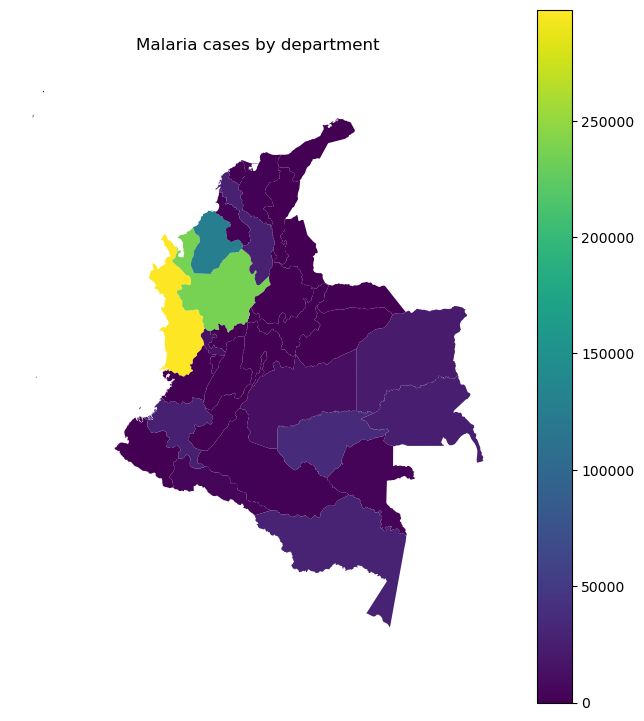

In [ ]:
df_dep = agg_malaria_by_department()
plot_malaria_map_departments(df_dep, title="Malaria cases by department") # Plot malaria by departament (absolute numbers) 

## Calculate indicators and indexes

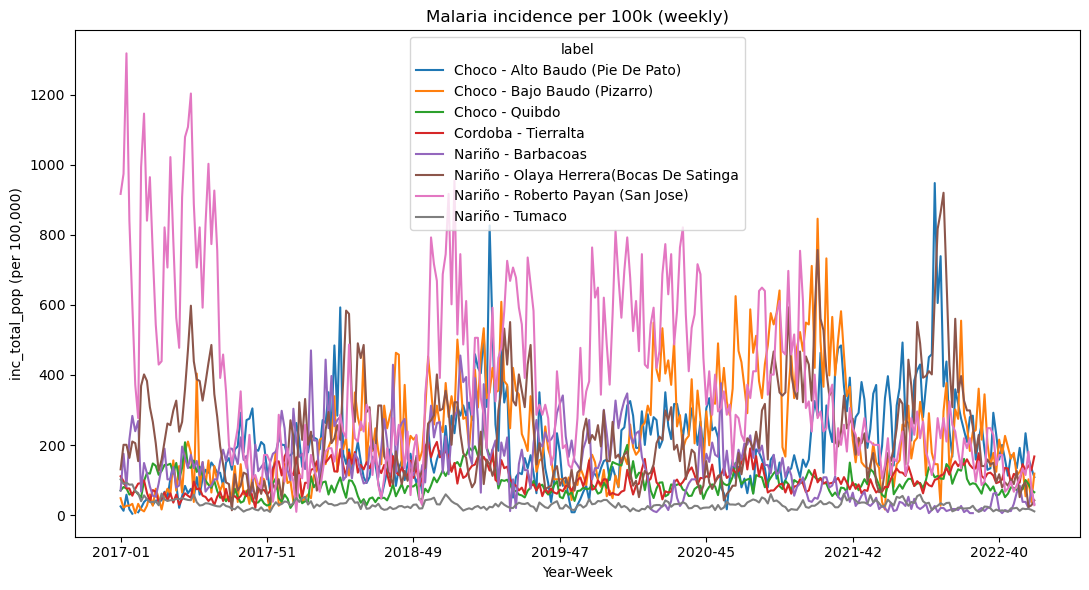

In [123]:
df_week = malaria_weekly_indicators(
    malaria_csv="data_raw/malaria_agg.csv",
    persons_csv="data_raw/cnper2018.csv",
    year_from=2017
)

# Quick peek
df_week.head()

# Plot: incidence per 100k, auto-pick top 8 municipalities by cases
ax, wide = plot_weekly_lines(df_week, metric="inc_total_pop", per=100000, top_k=8,
                                     title="Malaria incidence per 100k (weekly)")


In [196]:
df_week

,ano,semana,mpio_code,department,municipality,cases_total,cases_complicated,cases_vivax,cases_falciparum,pop_total,pop_u5,inc_total_pop,inc_comp_pop,inc_vivax_pop,inc_falci_pop,inc_total_u5,inc_comp_u5,inc_vivax_u5,inc_falci_u5
0,2017,1,05031,ANTIOQUIA,AMALFI,2,0,2,0,20265.0,1317.0,0.000099,0.000000,0.000099,0.000000,0.001519,0.000000,0.001519,0.000000
1,2017,1,05045,ANTIOQUIA,APARTADO,2,0,2,0,113469.0,8765.0,0.000018,0.000000,0.000018,0.000000,0.000228,0.000000,0.000228,0.000000
2,2017,1,05120,ANTIOQUIA,CACERES,2,0,2,0,26460.0,2381.0,0.000076,0.000000,0.000076,0.000000,0.000840,0.000000,0.000840,0.000000
3,2017,1,05147,ANTIOQUIA,CAREPA,2,0,1,1,45936.0,3698.0,0.000044,0.000000,0.000022,0.000022,0.000541,0.000000,0.000270,0.000270
4,2017,1,05154,ANTIOQUIA,CAUCASIA,2,0,2,0,84717.0,7147.0,0.000024,0.000000,0.000024,0.000000,0.000280,0.000000,0.000280,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21760,2022,52,52427,NARIÑO,MAGUI (PAYAN),7,0,2,5,18262.0,2417.0,0.000383,0.000000,0.000110,0.000274,0.002896,0.000000,0.000827,0.002069
21761,2022,52,52473,NARIÑO,MOSQUERA,12,0,11,1,10206.0,789.0,0.001176,0.000000,0.001078,0.000098,0.015209,0.000000,0.013942,0.001267
21762,2022,52,52490,NARIÑO,OLAYA HERRERA(BOCAS DE SATINGA,9,0,0,9,21415.0,2224.0,0.000420,0.000000,0.000000,0.000420,0.004047,0.000000,0.000000,0.004047
21763,2022,52,52621,NARIÑO,ROBERTO PAYAN (SAN JOSE),3,0,1,2,10473.0,1102.0,0.000286,0.000000,0.000095,0.000191,0.002722,0.000000,0.000907,0.001815


In [203]:
import pandas as pd

case_cols_base = ["cases_total", "cases_complicated", "cases_vivax", "cases_falciparum"]

# 1) Casos acumulados 2017–2022 por municipio
cases_sum = (
    df_week.groupby(["mpio_code", "municipality"], as_index=False)[case_cols_base]
           .sum()
)

# 2) Población fija por municipio (2018)
pop_by_mpio = (
    df_week.groupby("mpio_code")["pop_total"]
           .first()
           .reset_index()
)

# 3) Unir y calcular incidencias acumuladas (x 100,000)
out = cases_sum.merge(pop_by_mpio, on="mpio_code", how="left")

out["inc_total_pop"] = (out["cases_total"]        / out["pop_total"]) * 100000
out["inc_comp_pop"]  = (out["cases_complicated"]  / out["pop_total"]) * 100000
out["inc_vivax_pop"] = (out["cases_vivax"]        / out["pop_total"]) * 100000
out["inc_falci_pop"] = (out["cases_falciparum"]   / out["pop_total"]) * 100000


# 4) Resultado final
cols_keep = (
    ["mpio_code", "municipality"] +
    case_cols_base +
    ["inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"]
)
df_malaria_total = out[cols_keep].copy()


In [96]:
df_personas = pd.read_csv('data_raw/cnper2018.csv')
df_hogares = pd.read_csv('data_raw/cnhog2018.csv')
df_personas["v_analfabeta"] = (df_personas["P_ALFABETA"] == 2).astype(int)
df_personas["v_bajo_nivel"] = df_personas["P_NIVEL_ANOSR"].isin([1,2,10]).astype(int)
df_personas["v_edad_riesgo"] = df_personas["P_EDADR"].isin([1,13,14,15,16,17,18,19,20,21]).astype(int)
df_personas["v_trabajo"] = df_personas["P_TRABAJO"].isin([4,5,7,8,9]).astype(int)
df_personas["v_calidad_salud"] = df_personas["PA1_CALIDAD_SERV"].isin([3,4]).astype(int)

df_hogares["v_cocina"] = df_hogares["H_DONDE_PREPALIM"].isin([5,6]).astype(int)
df_hogares["v_agua"] = (~df_hogares["H_AGUA_COCIN"].isin([1,2,11])).astype(int)
df_hogares["v_hacinamiento"] = (df_hogares["HA_TOT_PER"] / df_hogares["H_NRO_DORMIT"] > 3).astype(int)

In [126]:
# Merge one-to-many (assign each person the values from the household)
df_vuln = df_personas.merge(df_hogares[["COD_ENCUESTAS","v_cocina","v_agua","v_hacinamiento"]],
                       on="COD_ENCUESTAS", how="left")


In [ ]:
# Construcción del índice por persona
vuln_vars = ["v_analfabeta","v_bajo_nivel","v_edad_riesgo",
             "v_trabajo","v_calidad_salud","v_cocina","v_agua","v_hacinamiento"]

df_vuln["IV"] = df_vuln[vuln_vars].mean(axis=1)


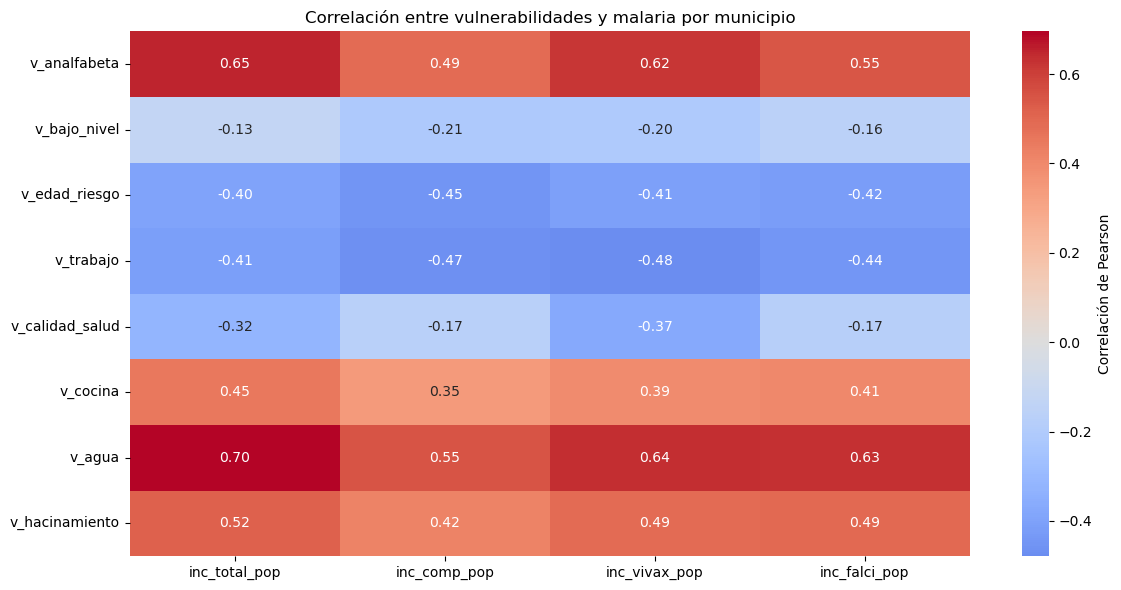

In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Variables de vulnerabilidad
vuln_vars = ["v_analfabeta","v_bajo_nivel","v_edad_riesgo",
             "v_trabajo","v_calidad_salud","v_cocina","v_agua","v_hacinamiento"]

# 2. Agregar vulnerabilidades por municipio (media = proporción vulnerable)
df_vuln_mpio = df_vuln.groupby(["U_DPTO","U_MPIO"])[vuln_vars].mean().reset_index()

# 3. Crear llave de municipio (5 dígitos: 2 depto + 3 municipio)
df_vuln_mpio["mpio_code"] = (
    df_vuln_mpio["U_DPTO"].astype(str).str.zfill(2) + 
    df_vuln_mpio["U_MPIO"].astype(str).str.zfill(3)
)

# 5. Merge vulnerabilidad + malaria
df_merged = df_malaria_total.merge(df_vuln_mpio, on="mpio_code", how="inner")

# 6. Variables de malaria
malaria_vars = ["inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"]

# 7. Correlación entre vulnerabilidades y malaria
corr = df_merged[vuln_vars + malaria_vars].corr(method='spearman').loc[vuln_vars, malaria_vars]

weights_rescale = (corr.mean(axis=1) + 1) / 2
weights_rescale = weights_rescale / weights_rescale.sum()

# 8. Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar_kws={'label': 'Correlación de Pearson'})
plt.title("Correlación entre vulnerabilidades y malaria por municipio")
plt.tight_layout()
plt.show()




In [205]:
w = weights_rescale.reindex(vuln_vars).fillna(0).astype(float)
w_sum = w.sum()
if w_sum <= 0:
    raise ValueError("La suma de los pesos es 0. Revisa weights_rescale.")
w = w / w_sum  # normaliza para que sumen 1

# 4) Calcular índice ponderado por municipio
df_vuln_mpio["IV_mpio"] = (df_vuln_mpio[vuln_vars] * w.values).sum(axis=1)

# (Opcional) Si quieres estandarizar el índice a [0,1]
# min_v, max_v = df_vuln_mpio["IV_mpio"].min(), df_vuln_mpio["IV_mpio"].max()
# if max_v > min_v:
#     df_vuln_mpio["IV_mpio_01"] = (df_vuln_mpio["IV_mpio"] - min_v) / (max_v - min_v)
# else:
#     df_vuln_mpio["IV_mpio_01"] = 0.0

# 5) Resultado
df_vuln_mpio_result = df_vuln_mpio.copy()
df_vuln_mpio_result

,U_DPTO,U_MPIO,v_analfabeta,v_bajo_nivel,v_edad_riesgo,v_trabajo,v_calidad_salud,v_cocina,v_agua,v_hacinamiento,mpio_code,IV_mpio
0,5,1,0.032289,0.260523,0.205170,0.288696,0.012991,0.004190,0.037096,0.038966,05001,0.077062
1,5,2,0.099077,0.600011,0.242334,0.340642,0.009946,0.006814,0.349379,0.063798,05002,0.188884
2,5,4,0.068258,0.469430,0.231993,0.353434,0.003769,0.007956,0.410804,0.070771,05004,0.183459
3,5,21,0.088776,0.536480,0.244898,0.334184,0.002041,0.009184,0.278827,0.035714,05021,0.162725
4,5,30,0.077539,0.425602,0.203073,0.349822,0.011954,0.008508,0.067129,0.052411,05030,0.112795
...,...,...,...,...,...,...,...,...,...,...,...,...
286,76,863,0.093520,0.500000,0.256225,0.359083,0.003396,0.004952,0.199774,0.042869,76863,0.148443
287,76,869,0.062279,0.386958,0.236004,0.323385,0.013370,0.019495,0.136548,0.055292,76869,0.122186
288,76,890,0.058967,0.401935,0.224398,0.319451,0.035855,0.023749,0.158133,0.056939,76890,0.128844
289,76,892,0.042611,0.306726,0.196363,0.284480,0.018922,0.013287,0.064305,0.059242,76892,0.092821


In [206]:
weights_rescale

v_analfabeta       0.179646
v_bajo_nivel       0.093742
v_edad_riesgo      0.066012
v_trabajo          0.062613
v_calidad_salud    0.084525
v_cocina           0.159259
v_agua             0.185553
v_hacinamiento     0.168650
dtype: float64

In [207]:
df_malaria_total

,mpio_code,municipality,cases_total,cases_complicated,cases_vivax,cases_falciparum,inc_total_pop,inc_comp_pop,inc_vivax_pop,inc_falci_pop
0,05001,MEDELLIN,109,20,66,21,4.594639,0.843053,2.782075,0.885206
1,05002,ABEJORRAL,2,0,2,0,11.364282,0.000000,11.364282,0.000000
2,05004,ABRIAQUI,1,0,0,1,46.317740,0.000000,0.000000,46.317740
3,05030,AMAGA,2,0,2,0,7.456844,0.000000,7.456844,0.000000
4,05031,AMALFI,47,1,41,5,231.926968,4.934616,202.319270,24.673082
...,...,...,...,...,...,...,...,...,...,...
241,52699,SANTA CRUZ (GUACHAVES),4,0,3,1,40.530956,0.000000,30.398217,10.132739
242,52786,TAMINANGO,19,1,8,10,123.280561,6.488451,51.907604,64.884506
243,52788,TANGUA,1,0,0,1,9.679605,0.000000,0.000000,9.679605
244,52835,TUMACO,13308,558,1407,11284,9637.123346,404.081367,1018.893338,8171.423192


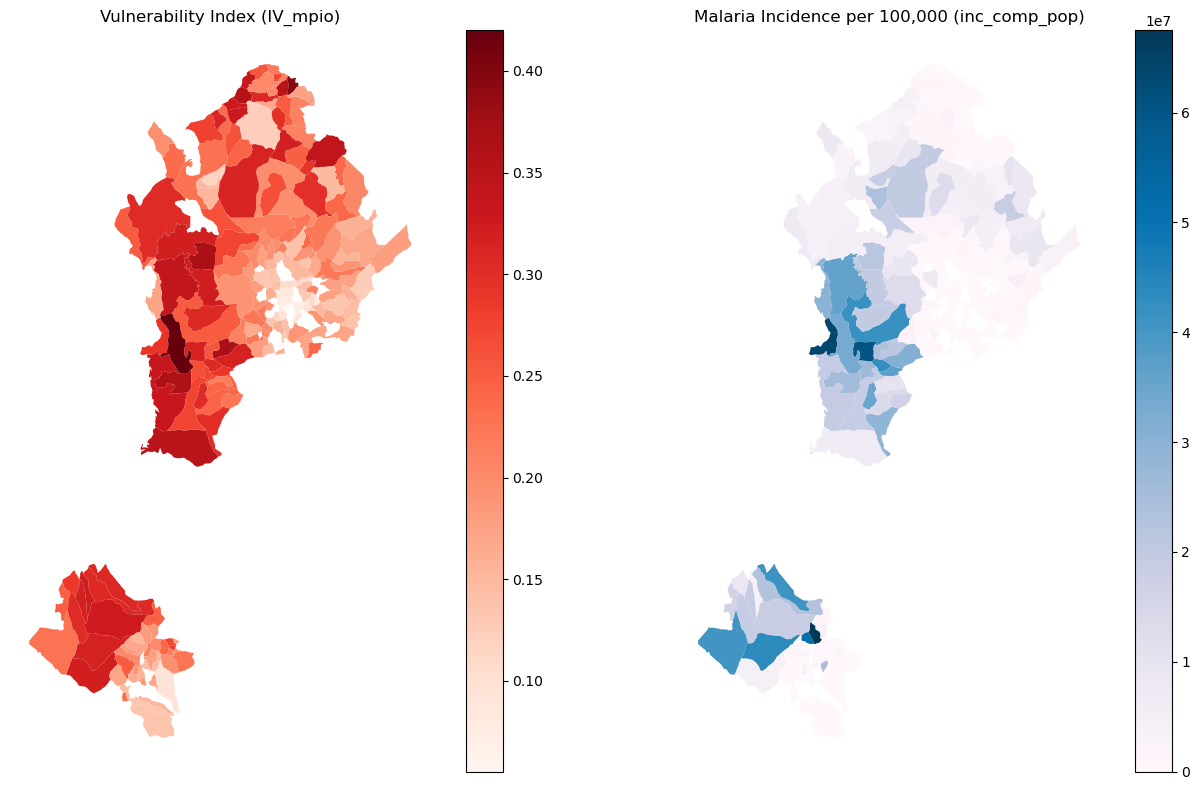

In [214]:
gdf_map = make_maps(df_vuln_mpio, df_malaria_total, gdf=gdf_mpios, malaria_col='inc_comp_pop')

In [215]:
gdf_map

,mpio_code,geometry,IV_mpio,municipality,cases_total,cases_complicated,cases_vivax,cases_falciparum,inc_total_pop,inc_comp_pop,inc_vivax_pop,inc_falci_pop,inc_comp_pop_100k
0,05885,"POLYGON ((-74.6022 6.762, -74.5976 6.7505, -74...",0.190904,YALI,2,0,2,0,32.082130,0.000000,32.082130,0.000000,0.000000e+00
1,05664,"POLYGON ((-75.4806 6.5017, -75.4806 6.4988, -7...",0.106853,SAN PEDRO,6,0,5,1,35.048776,0.000000,29.207314,5.841463,0.000000e+00
2,05125,"POLYGON ((-76.0697 6.5111, -76.0634 6.5111, -7...",0.181530,CAICEDO,4,0,4,0,56.996295,0.000000,56.996295,0.000000,0.000000e+00
3,52612,"POLYGON ((-77.9277 1.4971, -77.9144 1.4797, -7...",0.320917,RICAURTE,47,8,11,28,260.142802,44.279626,60.884486,154.978690,4.427963e+06
4,05315,"POLYGON ((-75.2312 6.9374, -75.2232 6.9287, -7...",0.197026,GUADALUPE,1,0,1,0,18.341893,0.000000,18.341893,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,52260,"POLYGON ((-77.41246 1.53624, -77.4031 1.526, -...",0.176957,EL TAMBO,2,0,1,1,16.055230,0.000000,8.027615,8.027615,0.000000e+00
206,05440,"POLYGON ((-75.33866 6.22203, -75.3294 6.229, -...",0.092042,MARINILLA,1,1,0,0,1.810610,1.810610,0.000000,0.000000,1.810610e+05
207,52838,"POLYGON ((-77.6075 1.1855, -77.6093 1.1711, -7...",0.164126,TUQUERRES,5,0,1,4,11.788838,0.000000,2.357768,9.431071,0.000000e+00
208,05483,"POLYGON ((-75.2363 5.6707, -75.2299 5.6614, -7...",0.241706,NARIÑO,8,0,3,5,92.990817,0.000000,34.871556,58.119261,0.000000e+00


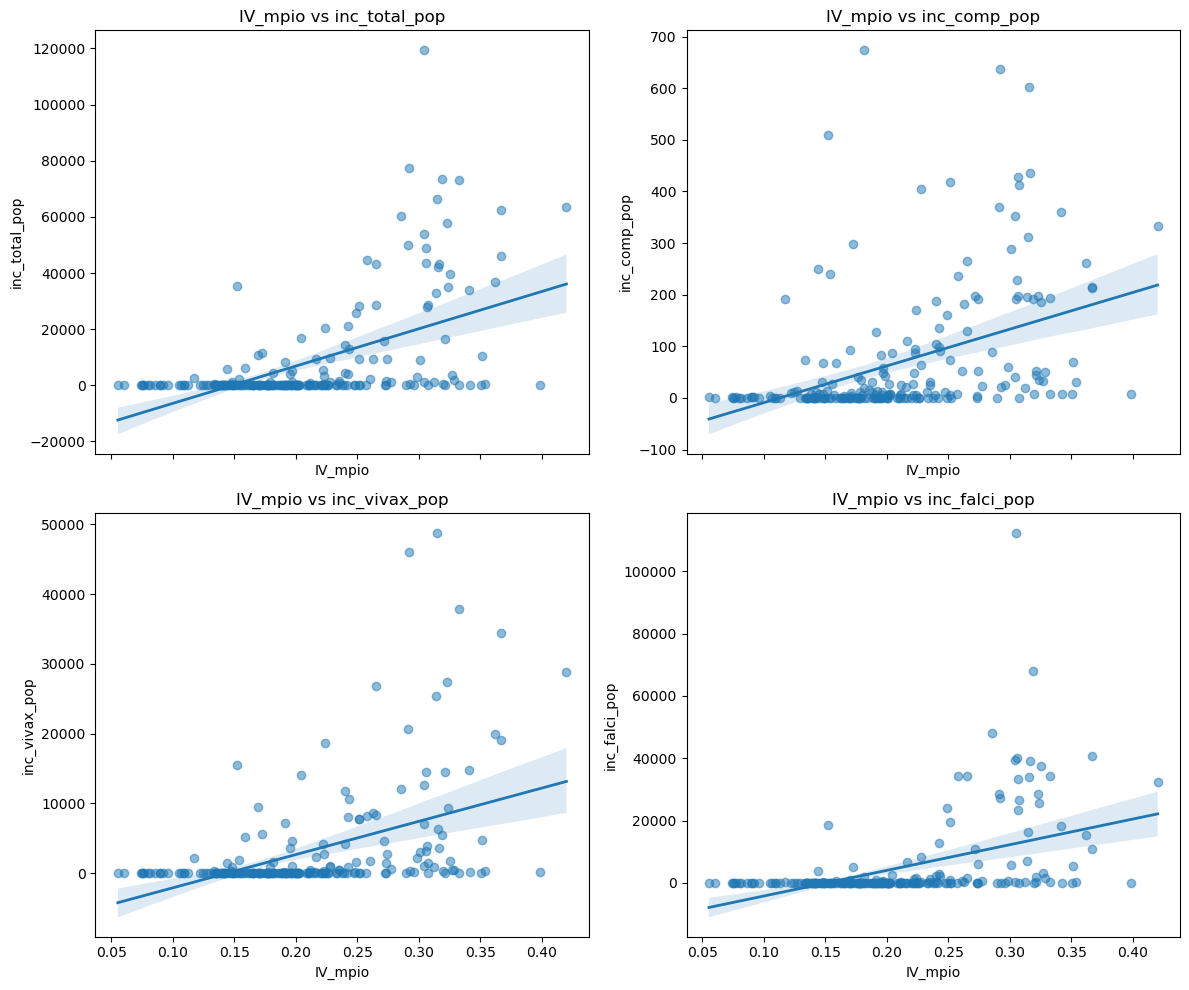

In [217]:
inc_vars = ["inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
axes = axes.ravel()

for ax, v in zip(axes, inc_vars):
    sns.regplot(
        data=gdf_map, x="IV_mpio", y=v, ax=ax,
        scatter_kws={"alpha": 0.5}, line_kws={"lw": 2}
    )
    ax.set_title(f"IV_mpio vs {v}")
    ax.set_xlabel("IV_mpio")
    ax.set_ylabel(v)

plt.tight_layout()
plt.show()


In [226]:
import libpysal
from esda.moran import Moran

# W: matriz de pesos espaciales (vecindad)
w = libpysal.weights.Queen.from_dataframe(gdf_map)
w.transform = "r"

# Tomemos una variable de incidencia
y = gdf_map["inc_total_pop"].values

moran = Moran(y, w)
print("Moran's I:", moran.I)
print("p-value:", moran.p_sim)


('WARNING: ', 93, ' is an island (no neighbors)')
Moran's I: 0.6142177086551142
p-value: 0.001


C:\Users\alina\AppData\Local\Temp\ipykernel_16148\1728186746.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf_map)


In [227]:
import libpysal
from esda.moran import Moran

# W: matriz de pesos espaciales (vecindad)
w = libpysal.weights.Queen.from_dataframe(gdf_map)
w.transform = "r"

# Tomemos una variable de incidencia
y_iv = gdf_map["IV_mpio"].values

moran = Moran(y, w)
print("Moran's I:", moran.I)
print("p-value:", moran.p_sim)

('WARNING: ', 93, ' is an island (no neighbors)')
Moran's I: 0.6142177086551142
p-value: 0.001


C:\Users\alina\AppData\Local\Temp\ipykernel_16148\836305245.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf_map)
c:\Users\alina\anaconda3\envs\policy-analytics\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 93.
  W.__init__(self, neighbors, ids=ids, **kw)


c:\Users\alina\anaconda3\envs\policy-analytics\Lib\site-packages\esda\moran.py:1351: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


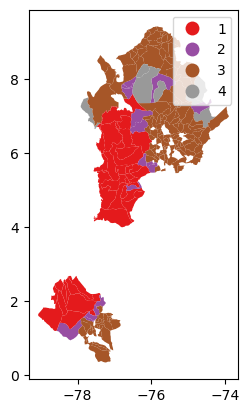

In [223]:
from esda.moran import Moran_Local

lisa = Moran_Local(y, w)

# Resultados por municipio
gdf_map["lisa_I"] = lisa.Is          # estadístico local
gdf_map["lisa_p"] = lisa.p_sim       # significancia
gdf_map["lisa_cluster"] = lisa.q     # tipo de cluster (1–4)

# Mapa rápido de clusters
import matplotlib.pyplot as plt
gdf_map.plot(column="lisa_cluster", categorical=True, legend=True, cmap="Set1")
plt.show()


c:\Users\alina\anaconda3\envs\policy-analytics\Lib\site-packages\esda\moran.py:1351: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


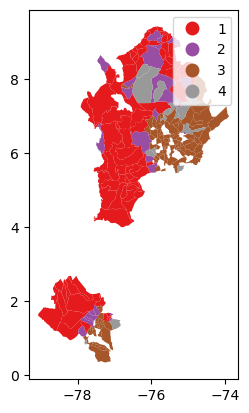

In [228]:
from esda.moran import Moran_Local

lisa = Moran_Local(y_iv, w)

# Resultados por municipio
gdf_map["lisa_I"] = lisa.Is          # estadístico local
gdf_map["lisa_p"] = lisa.p_sim       # significancia
gdf_map["lisa_cluster"] = lisa.q     # tipo de cluster (1–4)

# Mapa rápido de clusters
import matplotlib.pyplot as plt
gdf_map.plot(column="lisa_cluster", categorical=True, legend=True, cmap="Set1")
plt.show()